In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import math

from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict

### Load the dataset

In [41]:
df = pd.read_csv('SpamAssasin.csv')
df.head()

,sender,receiver,date,subject,body,label,urls
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0,1
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...","Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,1
2,"""Tim Chapman"" <timc@2ubh.com>",zzzzteana <zzzzteana@yahoogroups.com>,"Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,1
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient: ;,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,1
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,"Thu, 22 Aug 2002 14:38:22 +0100",Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,1


Label count

In [42]:
label_counts = df['label'].value_counts()
print(label_counts)

label
0    4091
1    1718
Name: count, dtype: int64


### Plot the distribution of labels in the dataset

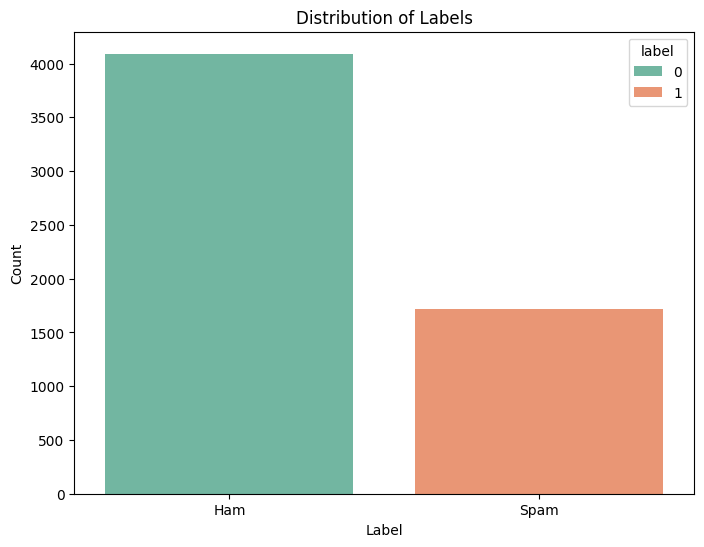

In [43]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', hue='label', data=df, palette='Set2')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### It is evident that there is significant difference in the number of spam emails and ham emails. Let's add some spam emails from `CEAS_08.csv` to the `SpamAssasin.csv` to balance the dataset

In [44]:
df_other = pd.read_csv('CEAS_08.csv')
df_other.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


Add 2800 spam emails

In [45]:
df_other_spam = df_other[df_other['label'] == 1].sample(n=2800, random_state=42)
df = pd.concat([df, df_other_spam], ignore_index=True)

In [46]:
new_label_counts = df['label'].value_counts()
print(new_label_counts)

label
1    4518
0    4091
Name: count, dtype: int64


### Combine sender, receiver, subject and body columns to create complete emails

In [47]:
df['email'] = df['sender'] + ' ' + df['receiver'] + ' ' + df['subject'] + ' ' + df['body']
df = df.drop(columns=["sender","receiver", "date", "subject", "body", "urls"])
df = df.reindex(columns=["email", "label"])
df.head()

,email,label
0,Robert Elz <kre@munnari.OZ.AU> Chris Garrigues...,0
1,"Steve Burt <Steve_Burt@cursor-system.com> ""'zz...",0
2,"""Tim Chapman"" <timc@2ubh.com> zzzzteana <zzzzt...",0
3,Monty Solomon <monty@roscom.com> undisclosed-r...,0
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk> zzzz...,0


Total emails present in the combined dataset

In [48]:
df.shape[0]

8609

Plot the distribution of labels in the combined dataset

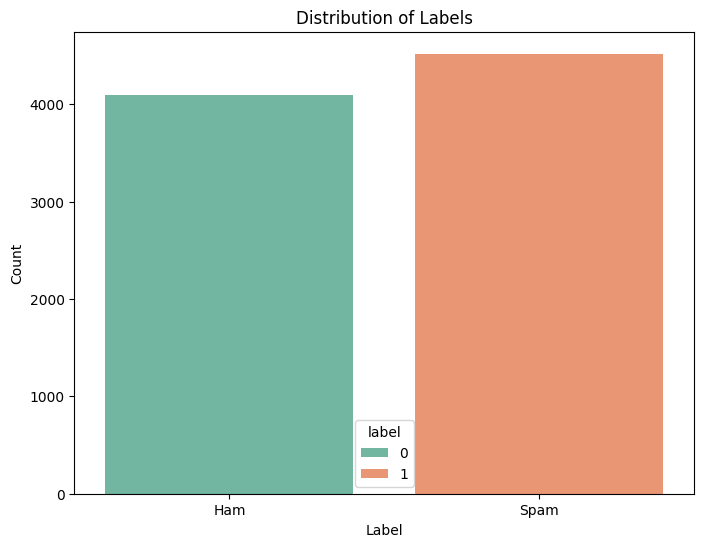

In [64]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', hue='label', data=df, palette='Set2')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### Split the combined dataset into train and test sets

In [50]:
X = df['email']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6887,), (1722,), (6887,), (1722,))

### Let's create a train folder which contains two folders - spam and ham, and store the train emails ($X_{train}$) as `.txt` files in the two folders accordingly.

In [53]:
def save_train_emails(X, y):
    if not os.path.exists('train'):
        os.makedirs('train')
    if not os.path.exists('train/spam'):
        os.makedirs('train/spam')
    if not os.path.exists('train/ham'):
        os.makedirs('train/ham')

    for index, (email, label) in enumerate(zip(X, y)):
        email = str(email)
        if label == 1:
            with open(f'train/spam/email_{index}.txt', 'w') as f:
                f.write(email)
        else:
            with open(f'train/ham/email_{index}.txt', 'w') as f:
                f.write(email)

save_train_emails(X_train, y_train)

### Let's create a test folder which contains two folders - spam and ham, and store the test emails ($X_{test}$) as `.txt` files in the two folders accordingly.

In [54]:
def save_test_emails(X, y):
    if not os.path.exists('test'):
        os.makedirs('test')
    if not os.path.exists('test/spam'):
        os.makedirs('test/spam')
    if not os.path.exists('test/ham'):
        os.makedirs('test/ham')

    for index, (email, label) in enumerate(zip(X, y)):
        email = str(email)
        if label == 1:
            with open(f'test/spam/email_{index}.txt', 'w') as f:
                f.write(email)
        else:
            with open(f'test/ham/email_{index}.txt', 'w') as f:
                f.write(email)

save_test_emails(X_test, y_test)

### We will use `NaiveBayesClassifier` for solving the spam classification problem. Let's define a class for the classifier.

In [55]:
class NaiveBayesClassifier:
    def __init__(self):
        self.spam_prior = 0
        self.ham_prior = 0
        self.spam_word_probs = {}
        self.ham_word_probs = {}
        self.spam_word_count = defaultdict(int)
        self.ham_word_count = defaultdict(int)
        self.total_spam_words = 0
        self.total_ham_words = 0


    # Load emails
    def load_emails(self, directory):
        emails = []
        for filename in os.listdir(directory):
            with open(os.path.join(directory, filename), 'r', encoding='latin-1') as f:
                emails.append(f.read())
        return emails


    # Data Preprocessing - Find and return all individual words in the email, excluding punctuations
    def preprocess_email(self, content):      # Content is the text present in an email
        content = content.lower()
        tokenized_words = re.findall(r'\b\w+\b', content)
        return tokenized_words


    # Extract features (Bag of Words)
    def extract_features(self, content):
        tokenized_words = self.preprocess_email(content)
        word_freqs = Counter(tokenized_words)
        return word_freqs               # A dictionary-like object where keys are words and values are their frequencies.


    # Train the classifier
    def train(self, spam_dir, ham_dir):

        # Email count
        spam_emails = self.load_emails(spam_dir)
        ham_emails = self.load_emails(ham_dir)
        total_emails = len(spam_emails) + len(ham_emails)

        # Set priors
        self.spam_prior = len(spam_emails) / total_emails
        self.ham_prior = len(ham_emails) / total_emails

        # Count words in emails
        for email in spam_emails:
            word_freqs = self.extract_features(email)
            for word, freq in word_freqs.items():
                self.spam_word_count[word] += freq
                self.total_spam_words += freq

        for email in ham_emails:
            word_freqs = self.extract_features(email)
            for word, freq in word_freqs.items():
                self.ham_word_count[word] += freq
                self.total_ham_words += freq

        # Calculate word probabilities with Laplace smoothing
        vocab = set(list(self.spam_word_count.keys()) + list(self.ham_word_count.keys()))
        vocab_size = len(vocab)

        for word in vocab:
            self.spam_word_probs[word] = (self.spam_word_count[word] + 1) / (self.total_spam_words + vocab_size)
            self.ham_word_probs[word] = (self.ham_word_count[word] + 1) / (self.total_ham_words + vocab_size)


    # Prediction
    def predict(self, content):
        word_freqs = self.extract_features(content)

        # Calculate the log probabilities for spam and ham
        spam_score = math.log(self.spam_prior)
        ham_score = math.log(self.ham_prior)

        for word, freq in word_freqs.items():
            # Use Laplace smoothing if the word does not exists
            spam_score += freq * math.log(self.spam_word_probs.get(word, 1 / (self.total_spam_words + len(self.spam_word_probs))))
            ham_score += freq * math.log(self.ham_word_probs.get(word, 1 / (self.total_ham_words + len(self.ham_word_probs))))

        if spam_score > ham_score:
            return 1
        else:
            return 0


    # Classify the emails in a folder
    def classify_emails(self, dir):
        predicted_labels = []
        for filename in os.listdir(dir):
            if os.path.isfile(os.path.join(dir, filename)):
              with open(os.path.join(dir, filename), 'r', encoding='latin-1') as f:
                  email = f.read()
                  prediction = self.predict(email)
                  predicted_labels.append(prediction)
        return predicted_labels


    # Accuracy
    def accuracy(self, true_labels, predicted_labels):
        correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
        total = len(true_labels)
        return correct / total

### Let's build the model using `NaiveBayesClassifier`.

In [56]:
nb_classifier = NaiveBayesClassifier()
nb_classifier.train('train/spam', 'train/ham')

### Prediction for test spam emails

In [57]:
spam_prediction = nb_classifier.classify_emails('test/spam')
print(spam_prediction)
spam_labels = [1] * len(spam_prediction)
print(f'Total number of test spam emails: {len(spam_prediction)}')
print(f'Number of spam emails that are correctly classfied: {sum(spam_prediction)}')
print(f'Number of spam emails that are incorrectly classfied: {len(spam_prediction) - sum(spam_prediction)}')
spam_accuracy = nb_classifier.accuracy(spam_labels, spam_prediction)
print(f"Accuracy for test spam emails: {spam_accuracy:.2f}")

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

### Prediction for test ham emails

In [58]:
ham_prediction = nb_classifier.classify_emails('test/ham')
print(ham_prediction)
ham_labels = [0] * len(ham_prediction)
print(f'Total number of test ham emails: {len(ham_prediction)}')
print(f'Number of ham emails that are correctly classfied: {len(ham_prediction) - sum(ham_prediction)}')
print(f'Number of ham emails that are incorrectly classfied: {sum(ham_prediction)}')
ham_accuracy = nb_classifier.accuracy(ham_labels, ham_prediction)
print(f"Accuracy for test ham emails: {ham_accuracy:.2f}")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### We will use the supplement dataset to test the classifier on new test emails

Prediction for spam emails of supplement dataset

In [62]:
spam_pred_sup = nb_classifier.classify_emails('supplement/spam')
print(spam_pred_sup)
spam_labels_sup = [1] * len(spam_pred_sup)
print(f'Total number of spam emails of supplement dataset: {len(spam_pred_sup)}')
print(f'Number of spam emails that are correctly classfied: {sum(spam_pred_sup)}')
print(f'Number of spam emails that are incorrectly classfied: {len(spam_pred_sup) - sum(spam_pred_sup)}')
spam_accuracy_sup = nb_classifier.accuracy(spam_labels_sup, spam_pred_sup)
print(f"Accuracy for the spam emails of supplement dataset: {spam_accuracy_sup:.2f}")

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Prediction for ham emails of supplement dataset

In [60]:
ham_pred_sup = nb_classifier.classify_emails('supplement/ham')
print(ham_pred_sup)
ham_labels_sup = [0] * len(ham_pred_sup)
print(f'Total number of ham emails of supplement dataset: {len(ham_pred_sup)}')
print(f'Number of ham emails that are correctly classfied: {len(ham_pred_sup) - sum(ham_pred_sup)}')
print(f'Number of ham emails that are incorrectly classfied: {sum(ham_pred_sup)}')
ham_accuracy_sup = nb_classifier.accuracy(ham_labels_sup, ham_pred_sup)
print(f"Accuracy for the ham emails of supplement dataset: {ham_accuracy_sup:.2f}")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 